In [90]:
import numpy as np
import cv2
import sys
import os
import shutil
import pandas as pd
import json
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)

In [8]:
# assume Nexar dataset is in 'data' folder
data_root = os.path.abspath('./data')
train_path = os.path.join(data_root, 'train')
train_desc_path = os.path.join(data_root, 'train.csv')
train_boxes_path = os.path.join(data_root, 'train_boxes.csv')

train_img_paths = os.listdir(train_path)
num_train = len(train_img_paths)

print 'data root path: ', data_root
print 'train path: ', train_path
print 'train examples: ', num_train

data root path:  /home/user/nexar/data
train path:  /home/user/nexar/data/train
train examples:  50000


In [63]:
names_df = pd.read_csv(train_desc_path)
labels_df = pd.read_csv(train_boxes_path)

labeled_image_names = list(set(labels_df['image_filename']))
missing_image_names = list(set(names_df['image_filename']).difference(labeled_image_names))

print '### train.csv ###'
print 'shape: ', names_df.shape
print names_df.head()
print '\n### train_boxes.csv ###'
print 'shape: ', labels_df.shape
print labels_df.head()
print 
print 'missing images: ', len(missing_image_names)
print labels_df['label'].value_counts()

labels_df.set_index('image_filename', inplace=True)

### train.csv ###
shape:  (50000, 3)
                                      image_filename  lighting city
0  frame_20f328fa-2459-46d0-97a5-5ae2d6103cb0_000...  Twilight  NYC
1  frame_927bde20-f97f-48c2-af30-f9127b6b32ce_000...       Day  NYC
2  frame_67012509-f3bd-4175-a9d2-565a7b6bb3c7_000...       Day  NYC
3  frame_bd043377-6fb8-407a-95e5-7deb1fbab13a_000...       Day  NYC
4  frame_4da1583b-58d0-4893-8149-54541191031d_000...       Day  NYC

### train_boxes.csv ###
shape:  (134361, 7)
                                      image_filename          x0          y0  \
0  frame_817c47b8-22c4-438a-8dc6-0e3f67f299ee_000...  601.600000  270.355731   
1  frame_817c47b8-22c4-438a-8dc6-0e3f67f299ee_000...  497.777778  308.774704   
2  frame_817c47b8-22c4-438a-8dc6-0e3f67f299ee_000...  449.422222  310.197628   
3  frame_a9110bf2-5252-4ec6-83c6-33b65d0fc04d_000...  711.111111  304.505929   
4  frame_a9110bf2-5252-4ec6-83c6-33b65d0fc04d_000...  584.533333  307.351779   

           x1          y1 lab

#### Convert DataFrame to ordinary python structures. Save/load annotations.

In [55]:
json_fname = 'annotations.json'

if os.path.exists(json_fname):
    annos = json.load(open(json_fname, 'r'))
    print 'loaded json file with %i entries' % len(annos)
else:
    annos = {}
    num_annos = len(labeled_image_names)
    for i, fname in enumerate(labeled_image_names):
        ann = []

        df = labels_df.loc[fname]
        if df.ndim > 1: # multiple boxes
            for row in df.itertuples():
                ann.append((row.x0, row.y0, row.x1, row.y1, row.label))
        else: # one box
            ann.append((df.x0, df.y0, df.x1, df.y1, df.label))

        annos[fname] = ann

        if i % 10000 == 0:
            print 'processed %i/%i' % (i, num_annos)

    json.dump(annos, open(json_fname, 'w'))
    print 'saved json file with %i entries' % len(annos)

loaded json file with 49282 entries


#### Collect some statistics

In [83]:
# collect all bounding boxes
boxes = np.zeros((0, 4))
for anno in annos.values():
    boxes_1 = np.zeros((len(anno), 4), dtype=np.float32)
    
    for i, item in enumerate(anno):
        boxes_1[i, :] = item[:4]
        
    boxes = np.vstack((boxes, boxes_1))

diags = np.sqrt((boxes[:, 2] - boxes[:, 0])**2 + (boxes[:, 3] - boxes[:, 1])**2)

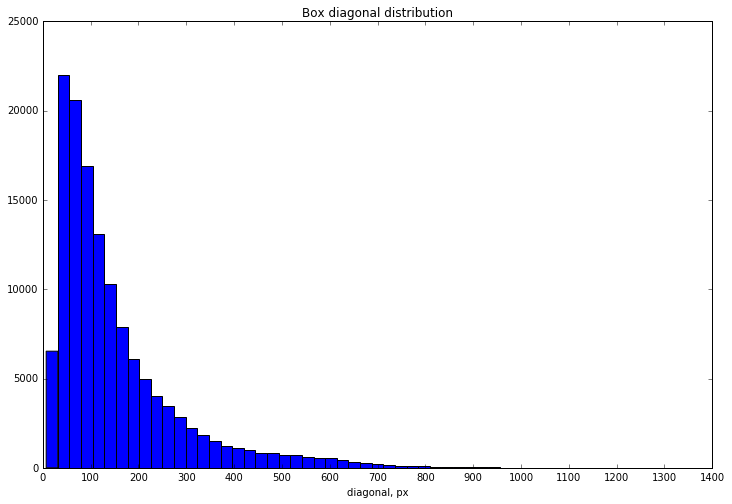

In [99]:
plt.figure(figsize=(12,8))
plt.hist(diags, 50);
plt.xticks(range(0, 1500, 100))
plt.xlabel('diagonal, px')
plt.title('Box diagonal distribution');

#### Save N random examples with annotations

In [57]:
# randomly select N examples
num_rnd_examples = 100
rnd_examples_names = np.random.choice(labeled_image_names, num_rnd_examples)

colors = {'pickup_truck': (255, 255, 0),
          'car': (255, 0, 0),
          'van': (0, 255, 0),
          'truck': (0, 0, 255),
          'bus': (0, 255, 255)}

def draw_legend(img):
    for i, t in enumerate(colors.keys()):
        org = (20, 12 + i * 10)
        res = cv2.putText(img, t, org, cv2.FONT_HERSHEY_PLAIN, 1, colors[t], 1)
    return res

def draw_box(img, x0, y0, x1, y1, label):
    x0, y0, x1, y1 = int(x0), int(y0), int(x1), int(y1)
    res = cv2.rectangle(img, (x0, y0), (x1, y1), colors[label], 2)
    return res

# draw boxes on random images and save
save_dir = './random_examples'
if os.path.exists(save_dir):
    shutil.rmtree(save_dir)
os.makedirs(save_dir)

for fname in rnd_examples_names:
    full_path = os.path.join(train_path, fname)
    img = cv2.imread(full_path)
    
    for item in annos[fname]:
        img = draw_box(img, *item)
        
    img = draw_legend(img)
        
    cv2.imwrite(os.path.join(save_dir, fname), img)